<hr style="height:2px;">

# Apply trained CARE model for for denoising of *X-ray Holographic Nanotomography* data

Adapted from demo notebook. 

This notebook demonstrates applying a CARE model for a 3D denoising task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

2021-09-02 23:38:36.578088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
#Check to see the GPUs are good:
print("Num GPUs:", len(tf.config.list_physical_devices('GPU') ))

Num GPUs: 4


2021-09-02 23:37:16.380566: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-02 23:37:16.383066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-02 23:37:16.540238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-09-02 23:37:16.541282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-09-02 23:37:16.542303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:83:00.0 name: 

In [3]:
# SET DATA PATH
datapath = "/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/"

<hr style="height:2px;">

# Raw low-SNR image and associated high-SNR ground truth

Plot the test stack pair and define its image axes, which will be needed later for CARE prediction.

image size = (256, 512, 512)
image axes = ZYX


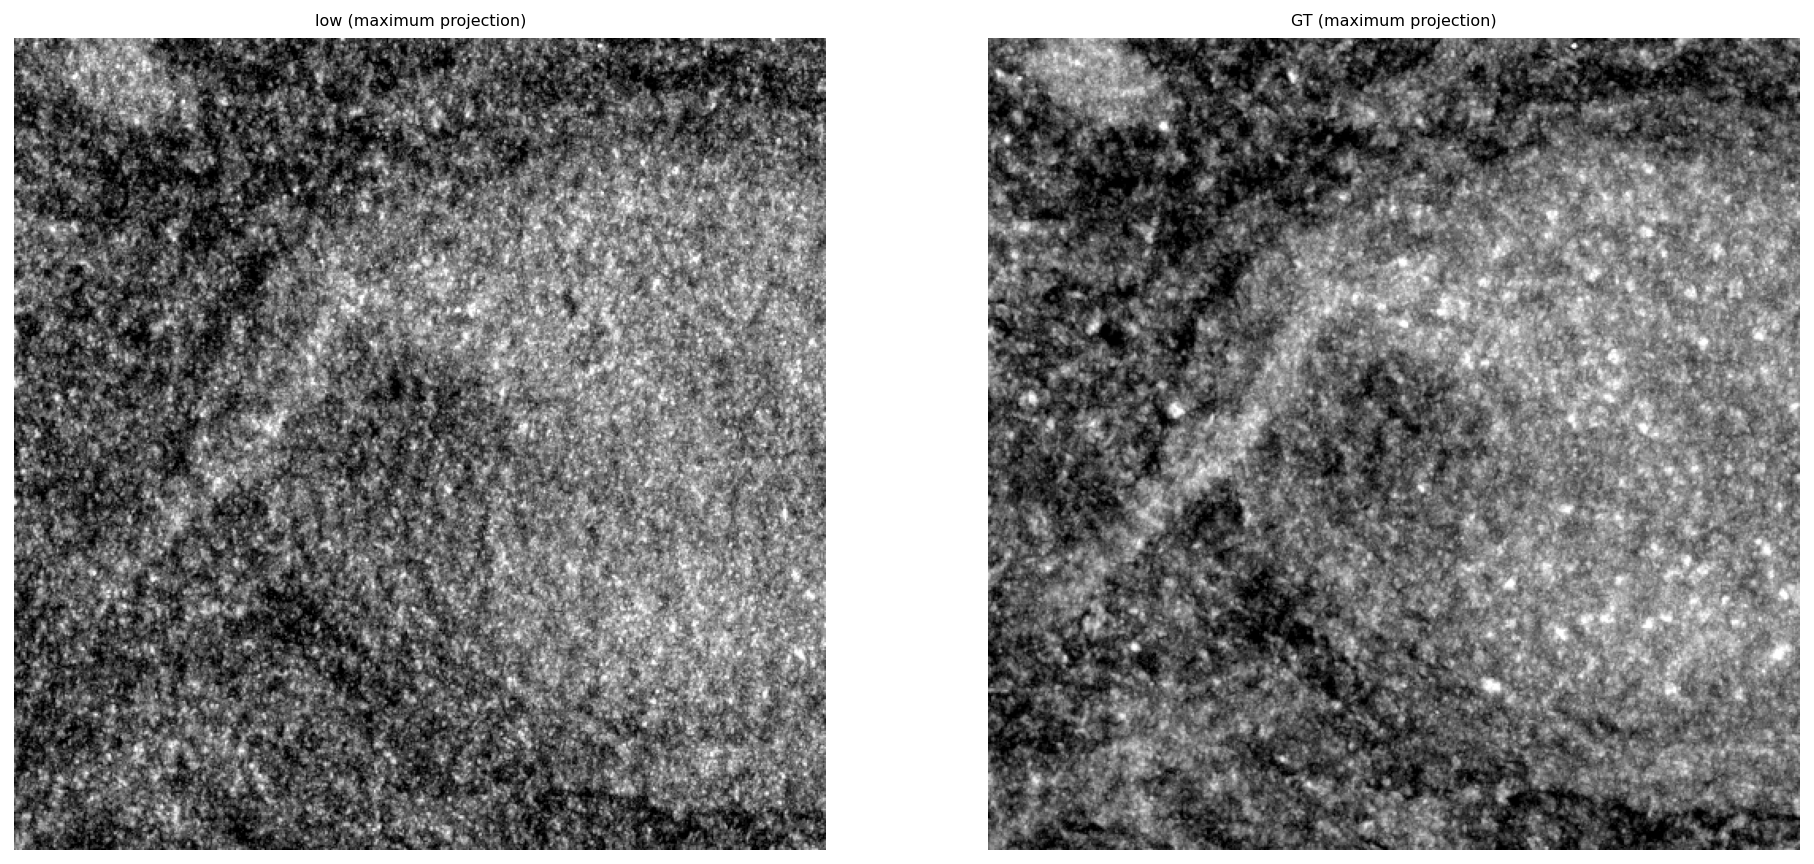

In [4]:
y = imread(datapath + 'test/GT/mCTX_17keV_30nm_512c_first256.tif')
x = imread(datapath + 'test/low/mCTX_17keV_30nm_512c_first256.tif')

axes = 'ZYX'
print('image size =', x.shape)
print('image axes =', axes)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8, cmap='gray');

<hr style="height:2px;">

# CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `CARE` is initialized with `config=None`.

In [5]:
model = CARE(config=None, name='kernSize3_depth2_450p', basedir='models')

2021-09-02 23:39:09.793144: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-02 23:39:09.795423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-02 23:39:09.951572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-09-02 23:39:09.952621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-09-02 23:39:09.953641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:83:00.0 name: 

Loading network weights from 'weights_best.h5'.


## Apply CARE network to raw image

Predict the restored image (image will be successively split into smaller tiles if there are memory issues).

In [ ]:
%%time
restored = model.predict(x, axes)

Alternatively, one can directly set `n_tiles` to avoid the time overhead from multiple retries in case of memory issues.

**Note**: *Out of memory* problems during `model.predict` can also indicate that the GPU is used by another process. In particular, shut down the training notebook before running the prediction (you may need to restart this notebook).

In [6]:
%%time
restored = model.predict(x, axes, n_tiles=(1,4,4))

2021-09-02 23:39:47.415832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-02 23:39:47.643736: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400140000 Hz
2021-09-02 23:39:49.782067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-09-02 23:39:52.118581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


CPU times: user 18.3 s, sys: 2.7 s, total: 21 s
Wall time: 23.3 s


## Save restored image

Save the restored image stack as a ImageJ-compatible TIFF image, i.e. the image can be opened in ImageJ/Fiji with correct axes semantics.

In [7]:
Path('results').mkdir(exist_ok=True)
save_tiff_imagej_compatible(datapath+'results/%s_mCTX_17keV_30nm_512c_first256.tif' % model.name, restored, axes)

<hr style="height:2px;">

# Raw low/high-SNR image and denoised image via CARE network

Plot the test stack pair and the predicted restored stack (middle).

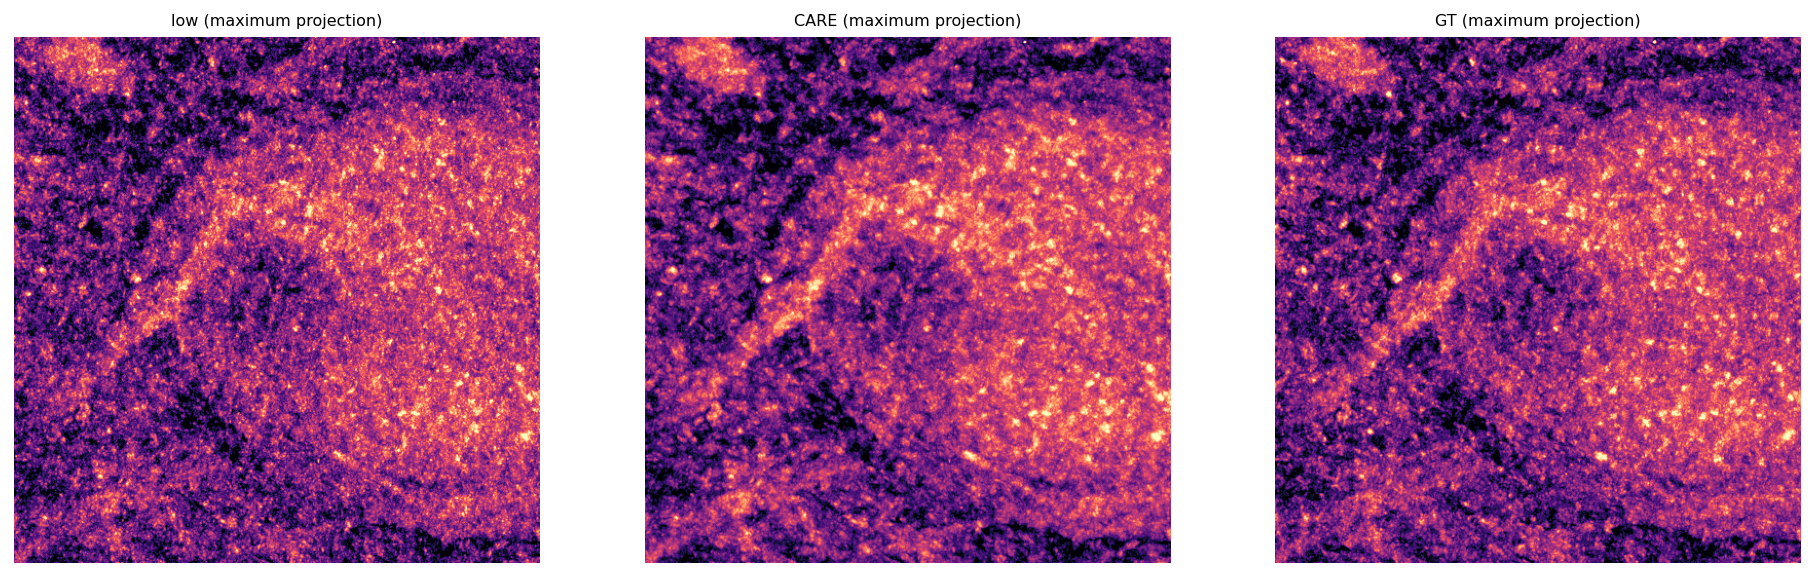

In [ ]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low (maximum projection)','CARE (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8, cmap='gray');